In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
from itertools import izip
print('[INFO] Using numpy {0}'.format(np.__version__))

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import initializers
from keras import regularizers
from keras import optimizers
from keras import losses
print('[INFO] Using keras {0}'.format(keras.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

import matplotlib.pyplot as plt
%matplotlib inline


# Globals
nlayers = 25  # 13 (CSC) + 9 (RPC) + 3 (GEM)

infile = '../test2/histos_tba.7.npz'

[INFO] Using numpy 1.12.1


Using Theano backend.


[INFO] Using keras 2.0.5
[INFO] Using sklearn 0.18.1


In [2]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_parameters = loaded['parameters']
    the_variables = loaded['variables']
except:
    print('[ERROR] Failed to load data')

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (2372461, 103)
[INFO] Loaded the parameters with shape (2372461, 3)


In [3]:
class Encoder(object):

  def __init__(self, x, y):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 4) + 3)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_mask  = self.x_copy[:, nlayers*3:nlayers*4].copy()  # avoid getting scaled
      self.x_road  = self.x_copy[:, nlayers*4:nlayers*5]  # ipt, ieta, iphi
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Modify phis
      self.x_phi_median    = self.x_road[:, 2] * 16  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Modify thetas
      self.x_theta_median  = np.nanmedian(self.x_theta, axis=1)
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Standard scales
      self.x_mean  = np.nanmean(self.x_copy, axis=0)
      self.x_std   = np.nanstd(self.x_copy, axis=0)
      self.x_std   = self._handle_zero_in_scale(self.x_std)
      self.x_copy -= self.x_mean
      self.x_copy /= self.x_std
      
      # Remove outlier hits (check thetas)
      x_theta_tmp = np.abs(self.x_theta) > 3.0
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      # Something wrong with GE2/1?
      bad_ge21 = 23
      self.x_phi  [:, bad_ge21] = np.nan
      self.x_theta[:, bad_ge21] = np.nan
      self.x_bend [:, bad_ge21] = np.nan
      self.x_mask [:, bad_ge21] = 1.0
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_theta_median = self.x_theta_median / 30.  # theta_int = 30 -> eta = 1.9
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, x_theta_median))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = np.abs(self.y_pt)  # weight (training only)
    w_new = w_new / 0.2 + 1.0
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']
    

In [4]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
encoder.save_encoder('encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.1)

nvariables = x_train.shape[1]
nparameters = 1

print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.12.1-mlhled2/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[INFO] Using 76 variables and 1 parameters


In [5]:
print x, y, w
print np.mean(x, axis=0)
print np.std(x, axis=0)
print np.isfinite(x).all()

[[-0.58553743  0.          0.         ...,  0.          0.          0.89999998]
 [-0.21926944  0.          0.         ...,  0.          0.          1.06666672]
 [ 0.          0.          0.         ...,  0.          0.          1.73333335]
 ..., 
 [-0.74092382  0.          0.         ...,  0.          0.          0.93333334]
 [ 0.         -0.85062295  0.         ...,  0.          0.          1.06666672]
 [ 0.          1.25189638  0.         ...,  0.          0.          0.68333334]] [-0.10976338 -0.03732378  0.04606546 ..., -0.08161429 -0.0964075   0.1291834 ] [ 1.54881692  1.18661892  1.23032737 ...,  1.4080714   1.48203754
  1.64591694]
[  8.97752296e-04  -3.73408257e-04   8.23743540e-05  -6.23670203e-05
   0.00000000e+00  -2.92502285e-04  -4.83726006e-04   1.04968072e-04
   1.44926540e-04  -3.27966991e-04   1.47033725e-05  -2.26099524e-04
  -1.32599220e-04   1.10706951e-05   8.56851966e-06  -7.52827737e-06
   3.97543663e-05   1.20106533e-05   1.90688877e-06   3.15314064e-05
   3.801

In [6]:
#### Create a model ####

# See https://keras.io/models/about-keras-models/
#     https://keras.io/layers/about-keras-layers/
# for all kinds of things you can do with Keras

# Define model
model = Sequential()
#model.add(Dense(8, input_dim=nvariables, activation='tanh', kernel_initializer='glorot_normal'))
#model.add(Dense(4, activation='tanh', kernel_initializer='glorot_normal'))
#model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

model.add(Dense(64, input_dim=nvariables, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(0.0000)))
model.add(Dense(32, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(0.0000)))
model.add(Dense(8, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(0.0000)))
model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

# Set loss and optimizer
import keras.backend as K
def huber_loss(y_true, y_pred, delta=1.345):
  x = K.abs(y_true - y_pred)
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  xx = K.switch(x < delta, squared_loss, absolute_loss)
  #return K.sum(xx, axis=-1)
  return K.mean(xx, axis=-1)

def smooth_huber_loss(y_true, y_pred):
  x = K.abs(y_true - y_pred)
  return K.mean(x + K.log(1 + K.exp(-2 * x)), axis=-1)

adam = optimizers.Adam(lr=0.0001, decay=0.000001,)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc', 'mse', 'mae'])
#model.compile(loss='mean_squared_error', optimizer=adam, metrics=['acc', 'mse', 'mae'])
#model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['acc', 'mse', 'mae'])
#model.compile(loss=huber_loss, optimizer='adam', metrics=['acc', 'mse', 'mae'])
model.compile(loss=huber_loss, optimizer=adam, metrics=['acc', 'mse', 'mae'])
#model.compile(loss='logcosh', optimizer='adam', metrics=['acc', 'mse', 'mae'])

In [7]:
#### Training ####

#history = model.fit(x_train, y_train, epochs=400, validation_split=0.2, batch_size=1000, verbose=1)

# The webpage can become very unresponsive when you train with a large dataset with the above comment.
# So I do the following instead.
# See issue https://github.com/jupyter/notebook/issues/1474

import sys
import time
start_time = time.time()
old_stdout = sys.stdout
sys.stdout = open('keras_output.txt', 'w')
#history = model.fit(x_train, y_train, epochs=40, validation_split=0.1, batch_size=1000, verbose=1)
history = model.fit(x_train, y_train, sample_weight=w_train, epochs=80, validation_split=0.1, batch_size=128, verbose=1)
sys.stdout.close()
sys.stdout = old_stdout

# Training time
print('[INFO] Time elapsed: {0} sec'.format(time.time() - start_time))

# Store model to file
model.save('model.h5')
model.save_weights('model_weights.h5')
model.summary()

[INFO] Time elapsed: 2242.32958102 sec
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4928      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 7,281
Trainable params: 7,281
Non-trainable params: 0
_________________________________________________________________


231000/237247 [============================>.] - ETA: 0s

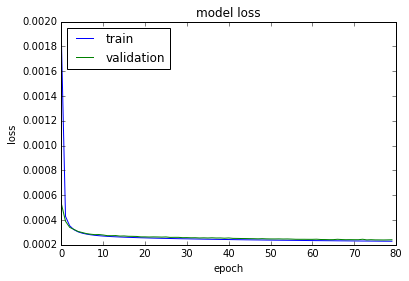

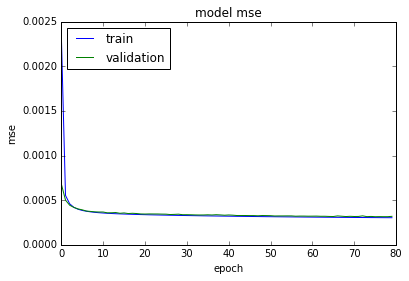

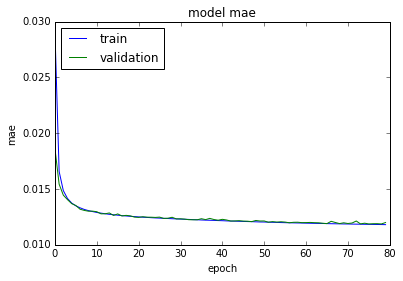

In [8]:
#### Evaluation using Keras internal tool ####

#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=1000)
loss_and_metrics = model.evaluate(x_test, y_test, sample_weight=w_test, batch_size=1000)

## Accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Mean Squared Error
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Mean Absolute Error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Welcome to JupyROOT 6.10/05
-0.000410234235099 0.0175169645855


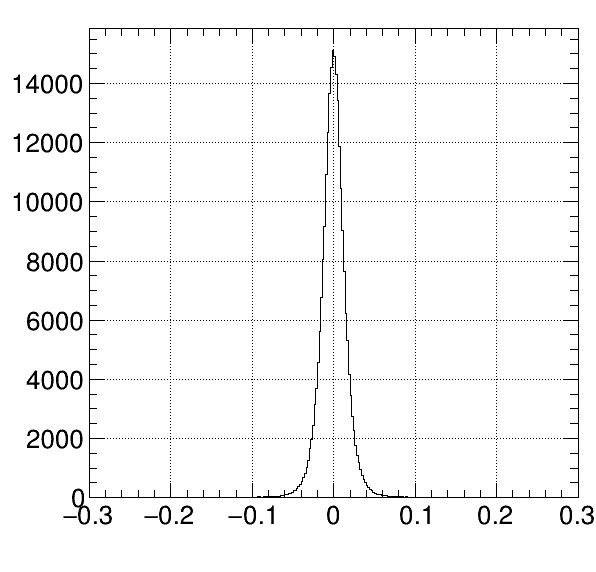

In [9]:
#### Application ####

from keras.models import load_model
import ROOT

# Load model
loaded_model = load_model('model.h5', custom_objects={'huber_loss': huber_loss})
loaded_model.load_weights('model_weights.h5')

ROOT.gROOT.LoadMacro("tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
ROOT.gStyle.SetPalette(57)  # kBird
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

h1 = ROOT.TH1F("h1", "h1", 300, -0.3, 0.3)
h2a = ROOT.TH2F("h2a", "h2a", 100, -0.5, 0.5, 300, -0.3, 0.3)
h2b = ROOT.TH2F("h2b", "h2b", 100, -0.5, 0.5, 300, -0.3, 0.3)
h2c = ROOT.TH2F("h2c", "h2c", 100, -0.5, 0.5, 400, -2, 2)
h2d = ROOT.TH2F("h2d", "h2d", 100, -0.5, 0.5, 400, -2, 2)

nentries_test = x_test.shape[0]
#nentries_test = 100000

y_test_meas = loaded_model.predict(x_test[:nentries_test, :])


# Loop over events
for i in xrange(nentries_test):
    y_true = y_test[i]
    y_meas = y_test_meas[i]
    h1.Fill(y_meas - y_true)
    h2a.Fill(y_true, y_meas - y_true) 
    h2b.Fill(y_true, y_meas)
    h2c.Fill(y_true, (y_meas - y_true)/abs(y_true))
    h2d.Fill(abs(y_true), (abs(y_meas) - abs(y_true))/abs(y_true)) 

# Draw
c = ROOT.TCanvas()
h1.Draw()
c.Draw()

print h1.GetMean(), h1.GetRMS()

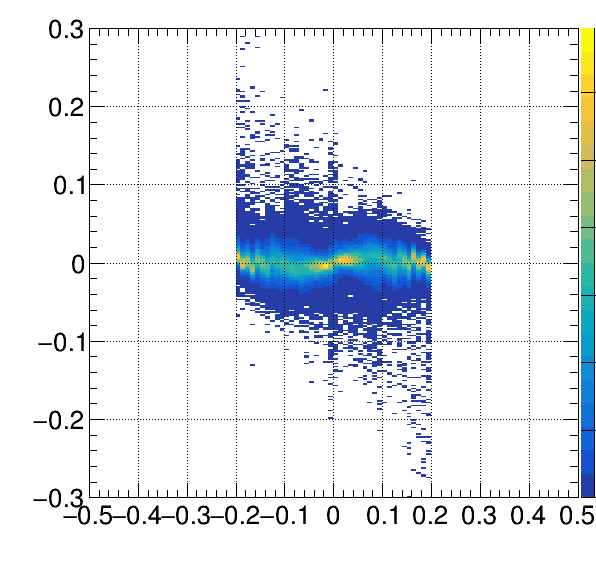

In [10]:
c = ROOT.TCanvas()
h2a.Draw("COLZ")
c.Draw()

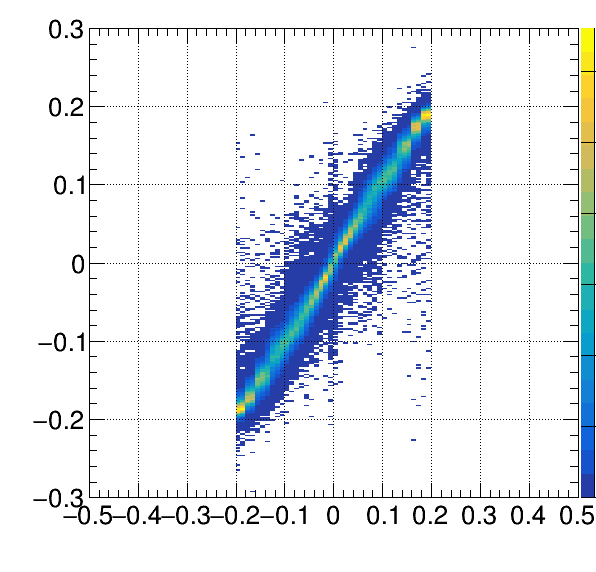

In [11]:
c = ROOT.TCanvas()
h2b.Draw("COLZ")
c.Draw()

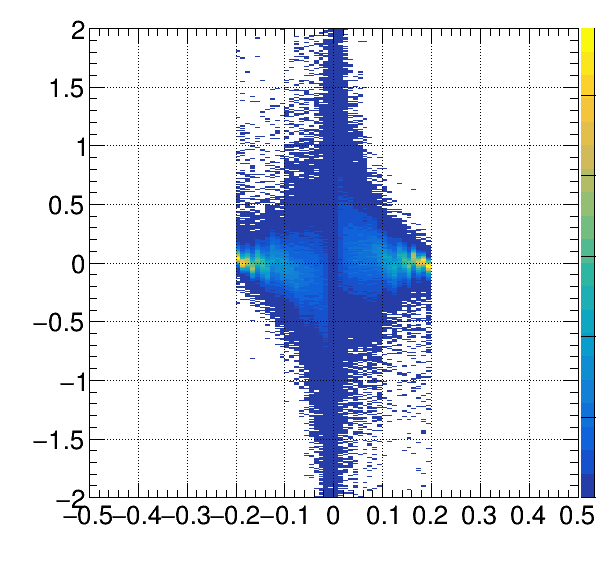

In [12]:
c = ROOT.TCanvas()
h2c.Draw("COLZ")
c.Draw()

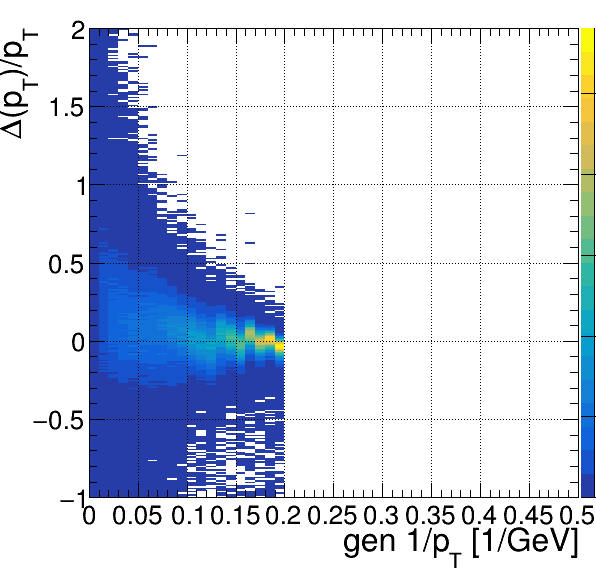

In [13]:
c = ROOT.TCanvas()
h2d.SetStats(0)
h2d.SetTitle("")
h2d.GetXaxis().SetTitle("gen 1/p_{T} [1/GeV]")
h2d.GetYaxis().SetTitle("#Delta(p_{T})/p_{T}")
h2d.GetXaxis().SetRangeUser(0, 0.5)
h2d.GetYaxis().SetRangeUser(-1, 2)
h2d.Draw("COLZ")
c.Draw()

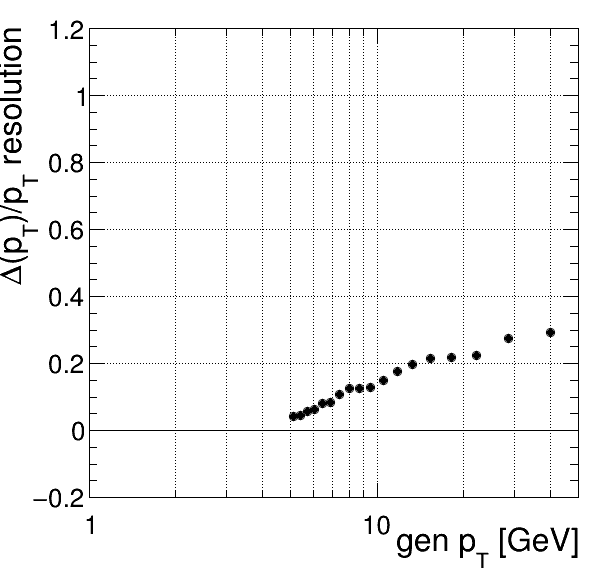

In [14]:
ccc = ROOT.TCanvas()

hname = "h2d"
h = h2d.Clone("h2d_clone")
h.Draw("COLZ")
#gPad.Print(hname+".png")
#h.RebinX(2)

h_pfx = h.ProfileX(hname+"_pfx", 1, -1, "s")
h_pfx.SetMaximum(1.2)
h_pfx.SetMinimum(-0.2)
h_pfx.Draw()
#h_pfx.Fit("pol1", "", "", 0.025, 0.2499)
#gPad.Print(h_pfx.GetName()+".png")
#

if True:
    # Apply gaussian fits
    gr1 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
    gr2 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
    gr1_aspt = ROOT.TGraphAsymmErrors(h.GetNbinsX())
    gr2_aspt = ROOT.TGraphAsymmErrors(h.GetNbinsX())
    for i in xrange(h.GetNbinsX()):
      h_py = h.ProjectionY("_py", i+1, i+1)
      if h_py.Integral() < 15:  continue
      #r = h_py.Fit("gaus", "SNQ")
      r = h_py.Fit("gaus", "SNQ", "", h_py.GetMean() - 0.04*8, h_py.GetMean() + 0.04*8)
      mean, sigma, meanErr, sigmaErr = r.Parameter(1), r.Parameter(2), r.ParError(1), r.ParError(2)
      gr1.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), mean)
      gr1.SetPointError(i, 0, 0, sigma, sigma)
      gr2.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), sigma)
      gr2.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
      gr1_aspt.SetPoint(i, 1.0/h.GetXaxis().GetBinCenter(i+1), mean)
      gr1_aspt.SetPointError(i, 0, 0, sigma, sigma)
      gr2_aspt.SetPoint(i, 1.0/h.GetXaxis().GetBinCenter(i+1), sigma)
      gr2_aspt.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
    #
    hname1 = hname
    h_pfx = h.ProfileX(hname1+"_pfx", 1, -1, "s")
    h_pfx.Reset()
    h_pfx.SetMaximum(1.2)
    h_pfx.SetMinimum(-0.2)
    h_pfx.Draw()
    gr1.Draw("p")
    #gr1.Fit("pol1", "", "", 0.025, 0.2499)
    #gPad.Print(h_pfx.GetName()+".png")
    #
    hname2 = hname
    h_pfx = h.ProfileX(hname2+"_pfx", 1, -1, "s")
    h_pfx.Reset()
    h_pfx.SetMaximum(1)
    h_pfx.SetMinimum(0)
    h_pfx.Draw()
    gr2.Draw("p")
    #gr2.Fit("pol1", "", "", 0.025, 0.2499)
    #gPad.Print(h_pfx.GetName()+".png")
    #
    hname1 = hname
    h_pfx = h.ProfileX(hname1+"_pfx", 1, -1, "s")
    h_pfx.Reset()
    h_pfx.SetBins(50, 0, 50)
    h_pfx.GetXaxis().SetTitle("gen p_{T} [GeV]")
    h_pfx.GetYaxis().SetTitle("#Delta(p_{T})/p_{T} bias")
    h_pfx.SetMaximum(1.2)
    h_pfx.SetMinimum(-0.2)
    h_pfx.Draw()
    gr1_aspt.Draw("p")
    #gr1_aspt.Fit("pol1", "", "", 0.025, 0.2499)
    #ROOT.gPad.SetLogx(1)
    #ROOT.gPad.Print(h_pfx.GetName()+".png")
    #ROOT.gPad.SetLogx(0)
    #
    hname2 = hname
    h_pfx = h.ProfileX(hname2+"_pfx", 1, -1, "s")
    h_pfx.Reset()
    h_pfx.SetStats(0)
    h_pfx.SetBins(50, 0, 50)
    h_pfx.GetXaxis().SetTitle("gen p_{T} [GeV]")
    h_pfx.GetYaxis().SetTitle("#Delta(p_{T})/p_{T} resolution")
    h_pfx.SetMaximum(1.2)
    h_pfx.SetMinimum(-0.2)
    #h_pfx.SetMaximum(0.1)
    #h_pfx.SetMinimum(-0.01)
    h_pfx.Draw()
    gr2_aspt.Draw("p")
    #gr2_aspt.Fit("pol1", "", "", 0.025, 0.2499)
    ROOT.gPad.SetLogx(1)
    #ROOT.gPad.Print(h_pfx.GetName()+".png")
    #ROOT.gPad.SetLogx(0)
    
ccc.Draw()

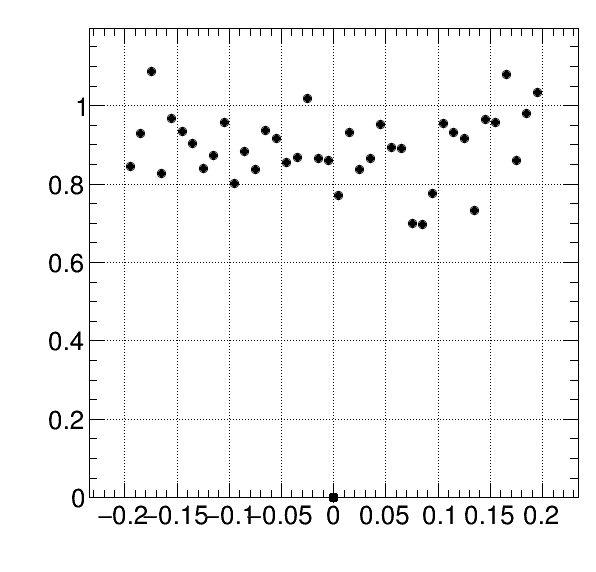

In [26]:
cccc = ROOT.TCanvas()

hname = "h2b"
h = h2b.Clone("h2b_clone")

if True:
  gr1 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr2 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr3 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  for i in xrange(h.GetNbinsX()):
    h_py = h.ProjectionY("_py", i+1, i+1)
    if h_py.Integral() < 15:  continue
    #r = h_py.Fit("gaus", "SNQ")
    r = h_py.Fit("gaus", "SNQ", "", h_py.GetMean() - 0.04*5, h_py.GetMean() + 0.04*5)
    mean, sigma, meanErr, sigmaErr = r.Parameter(1), r.Parameter(2), r.ParError(1), r.ParError(2)
    #mean, sigma, meanErr, sigmaErr = h_py.GetMean(), h_py.GetRMS(), 0, 0  #FIXME
    gr1.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), mean)
    gr1.SetPointError(i, 0, 0, sigma, sigma)
    gr2.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), sigma)
    gr2.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
    #print h_py.Integral(), h_py.Integral(h_py.FindBin(mean-sigma), h_py.FindBin(mean+sigma))
    loss = 1.0 - h_py.Integral(h_py.FindBin(mean-sigma), h_py.FindBin(mean+sigma)) / h_py.Integral()
    gr3.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), (1-loss)/loss)
    gr3.SetPointError(i, 0, 0, 0, 0)
  #
  #gr1.Draw("ap")
  #gr2.Draw("ap")
  gr3.Draw("ap")

cccc.Draw()

In [ ]:
########################## IGNORE

In [ ]:
# Generate dummy data
x_train = np.random.random((1000, 3))
y_train = np.array([1.0 * x[0] + 2.0 * x[1] + 3.0 * x[2] for x in x_train])
y_train.reshape((1000,1))

x_test = np.random.random((100, 3))
y_test = np.array([1.0 * x[0] + 2.0 * x[1] + 3.0 * x[2] for x in x_test])
y_test.reshape((100,1))

print x_train[0], y_train[0]

x_train_mask = np.random.randint(2, size=1000)
x_train_1 = np.concatenate((x_train, x_train_mask[:,np.newaxis]), axis=1)

for i in xrange(1000):
    if x_train_1[i][3]:
        x_train_1[i][2] = 0.

x_test_mask = np.ones((100,1))

x_test_1 = np.concatenate((x_test, x_test_mask), axis=1)

print x_train[0], x_train_mask[0], x_train_1[0]

In [ ]:
model = Sequential()
#model.add(Dense(3, activation='tanh', kernel_initializer='ones', input_dim=3))
#model.add(Dense(1, activation='linear', kernel_initializer='ones'))
model.add(Dense(1, activation='linear', kernel_initializer='ones', input_dim=4))

#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
model.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(lr=0.01), metrics=['acc'])

#model.fit(x_train, y_train, epochs=200, batch_size=128, verbose=0)
model.fit(x_train_1, y_train, epochs=200, batch_size=128, verbose=0)

#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)
loss_and_metrics = model.evaluate(x_test_1, y_test, batch_size=128)
print loss_and_metrics

print model.get_weights()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

In [ ]:
print x_train.shape, y_train.shape, x_mask_train.shape

fig, axs = plt.subplots(76/4, 4, figsize=(4*4,4*76/4), tight_layout=True)

for i in xrange(x_train.shape[1]):
  mask = x_mask_train[...,(i%25)]
  mask = mask.astype(np.bool)
  
  #fig, ax = plt.subplots(tight_layout=True)
  xmin, xmax = -4, 4
  ymin, ymax = -0.2, 0.2
  hist = axs[(i/4, i%4)].hist2d(x_train[...,i][~mask], y_train[~mask], bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

i = 50  # ME1/1 bend
mask = x_mask_train[...,(i%25)]
mask = mask.astype(np.bool)

hist = ax.hist(x_train[...,i][~mask], bins=40)

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist(encoder.x_theta_median, bins=40)

fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist(x_train[...,75], bins=40)
